### Imports

In [34]:
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from umap import UMAP
import numpy as np
import warnings
warnings.filterwarnings("ignore") # Some log2(0) in the DE analysis raises runtime errors, but we supress because it just means its not significant

### Reading in Data

In [35]:
%%time
#Change this to the appropriate data path
data_path = '/tscc/projects/ps-malilab/ydoctor/CM4AI/Perturb-seq_10_26_23/iPSC/mudata_files/KOLF_Chroma_mixscape_output_x_pert.h5ad'
adata = ad.read_h5ad(data_path) #Note that the .X is already set to the X_pert layer

CPU times: user 1.65 s, sys: 2.64 s, total: 4.28 s
Wall time: 9.63 s


### Creating Perturbation Network

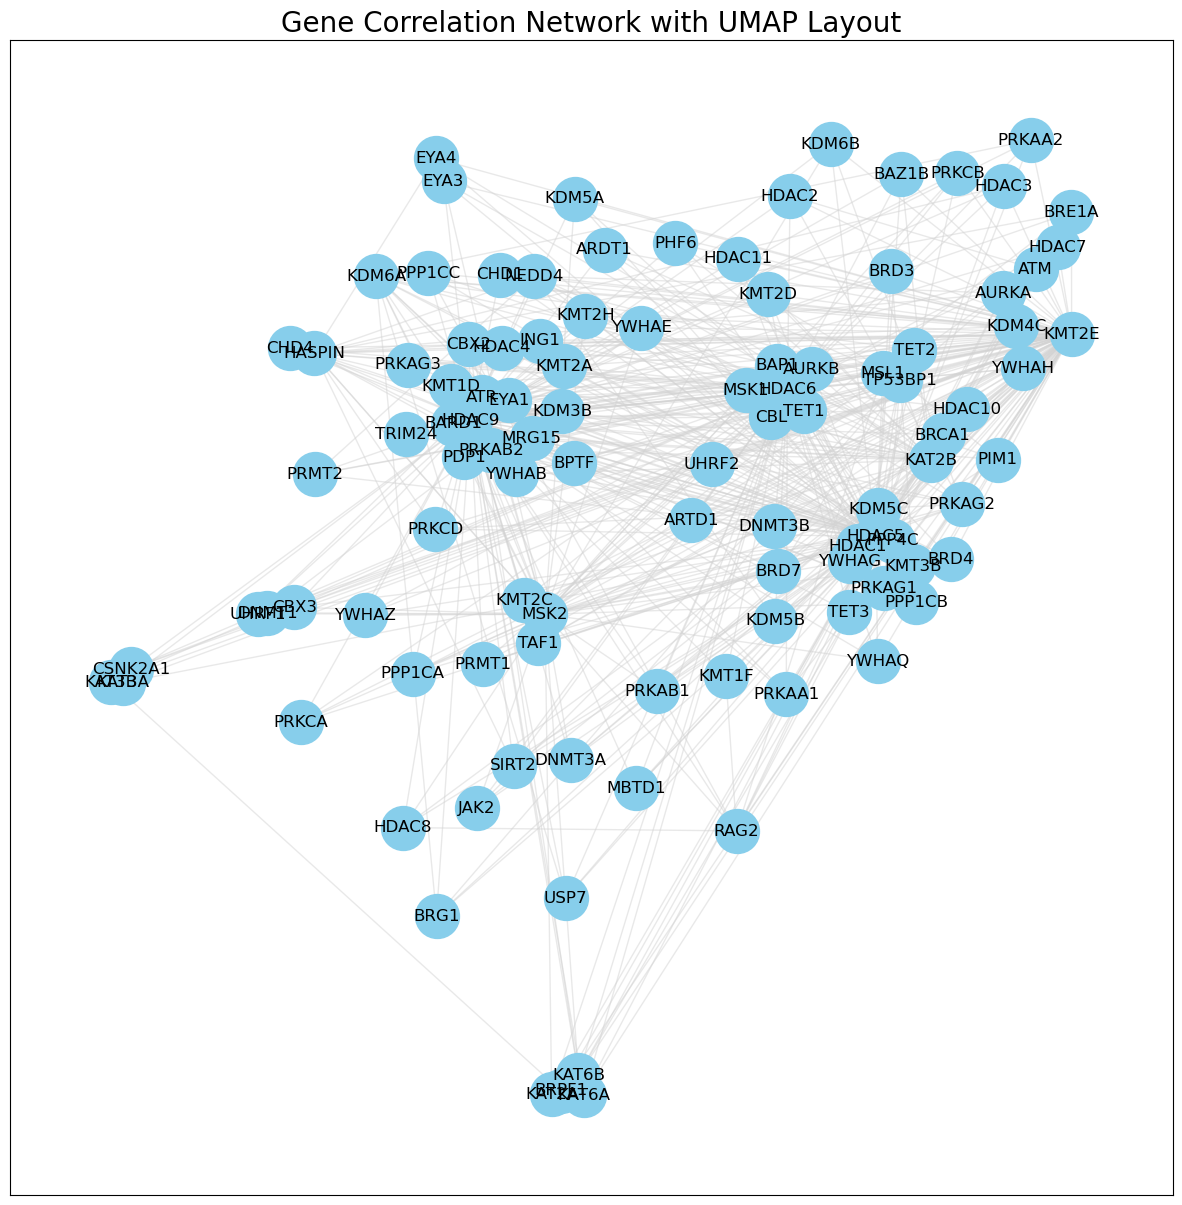

In [36]:
def create_perturbation_network(adata, target_genes_category='perturbation_target_genes'):
    # Filter cells with mixscape_class_global as 'KO'
    ko_cells = adata[adata.obs['mixscape_class_global'] == 'KO']

    # Get the list of perturbations
    unique_genes = ko_cells.obs[target_genes_category].unique()
    
    # Compute average expression for each gene
    avg_expression = {}
    for gene in unique_genes:
        cells_gene = ko_cells[ko_cells.obs[target_genes_category] == gene, :]
        sc.pp.normalize_total(cells_gene, target_sum=1e4) #this is not strictly necessary, as the data was normalized prior to the X_pert; this is essentially an arbitrary rescaling
        avg_expression[gene] = cells_gene.to_df().mean()

    # Create DataFrame for the expression data
    expression_df = pd.DataFrame(avg_expression)

    # Compute Pearson correlation matrix
    correlation_matrix = expression_df.corr(method='pearson')

    # Convert correlation to distance
    distance_matrix = 1 - correlation_matrix.values

    # Compute the 2D positions of the nodes using UMAP
    umap = UMAP(n_components=2, metric='precomputed', n_neighbors=3, min_dist=0.1, spread=10)
    positions = umap.fit_transform(distance_matrix)

    # Convert positions to a dictionary for NetworkX
    positions_dict = {gene: positions[i] for i, gene in enumerate(correlation_matrix.columns)}

    # Create the graph
    G = nx.Graph()

    # Add nodes and edges
    for gene in correlation_matrix.columns:
        G.add_node(gene)
        nearest_neighbor_indices = np.argsort(-np.abs(correlation_matrix.loc[gene].values))[:6]
        for idx in nearest_neighbor_indices:
            neighbor = correlation_matrix.columns[idx]
            if neighbor != gene:  # Avoid self-loops
                G.add_edge(gene, neighbor)

    # Visualize the graph
    plt.figure(figsize=(15, 15))
    nx.draw_networkx_nodes(G, positions_dict, node_size=1000, node_color='skyblue')
    nx.draw_networkx_edges(G, positions_dict, alpha=0.5, edge_color="lightgray")
    nx.draw_networkx_labels(G, positions_dict)
    plt.title("Gene Correlation Network with UMAP Layout", fontsize=20)
    plt.grid(False)  # Turn off the grid
    plt.show()

create_perturbation_network(adata)

### Computing Differentially Expressed Genes

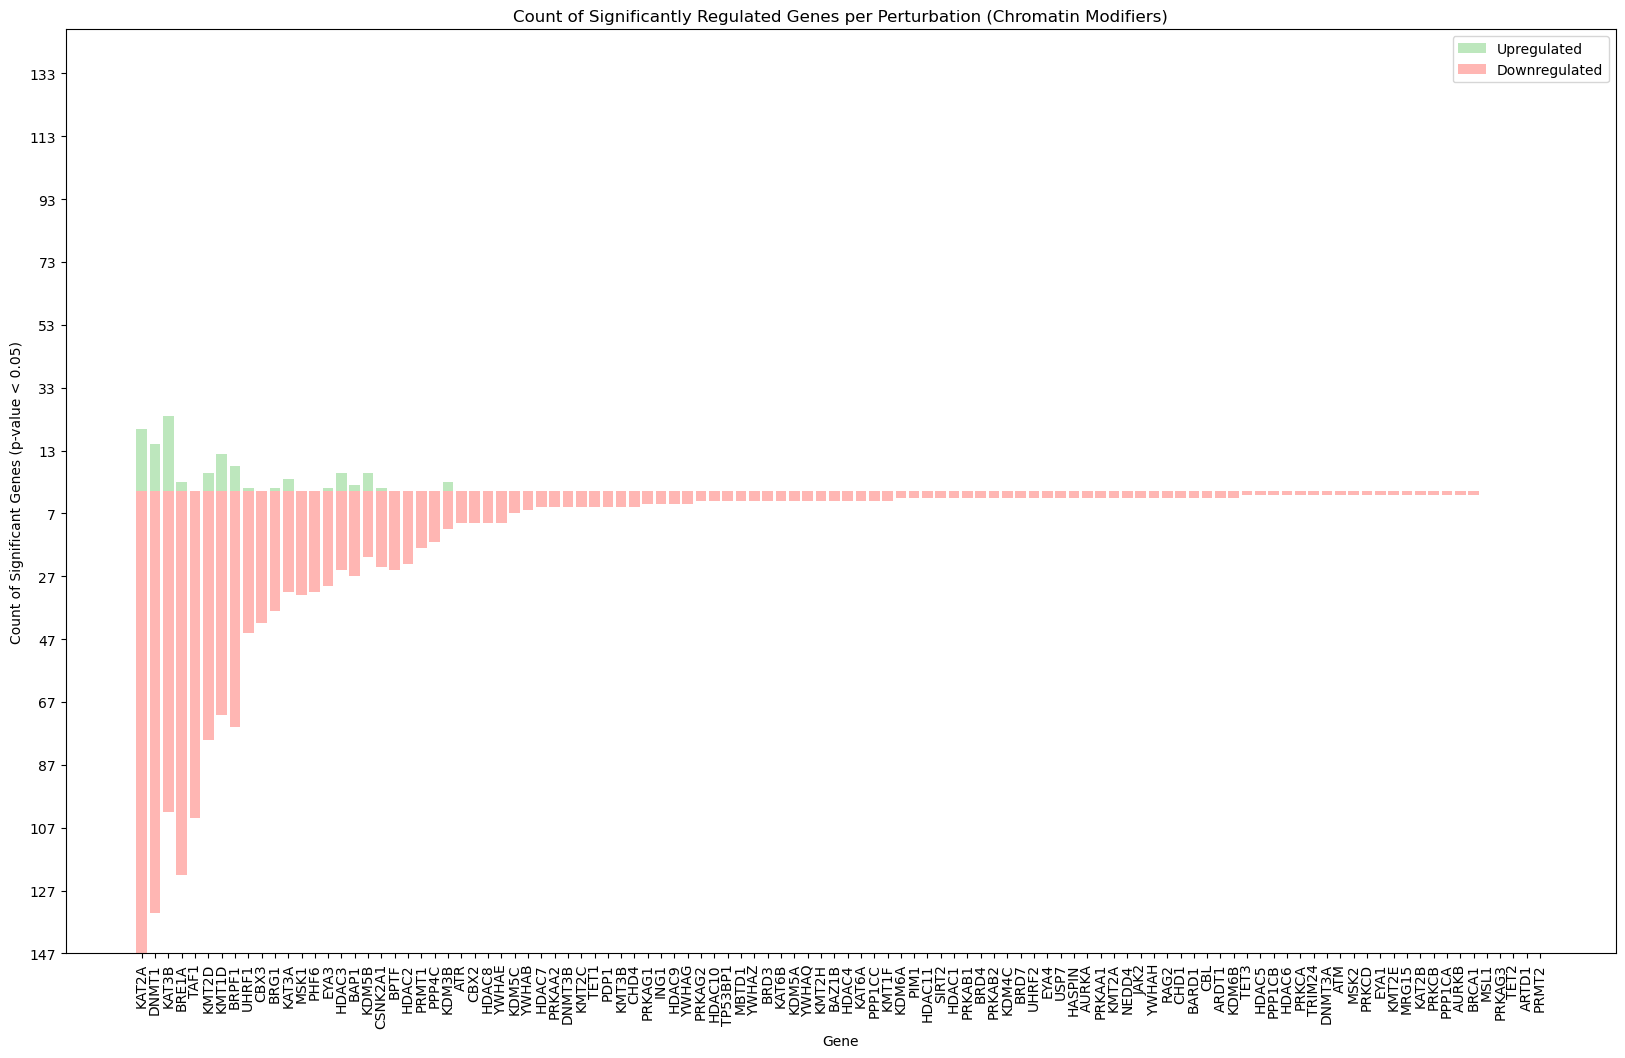

CPU times: user 5min 32s, sys: 28.6 s, total: 6min
Wall time: 6min 1s


In [37]:
%%time
def create_differential_gene_expression_plot(adata, pvalue_threshold=-np.log10(0.05)):

    # Isolate only cells identified as having a mixscape_class_global of "KO" or "NT" corresponding to perturbed or non targeting controls
    # Note that "KO" actually represents a Knock-Down in this application as CRISPRi is used
    adata_ko = adata[adata.obs['mixscape_class_global'].isin(['NT',"KO"])].copy()
    genes_of_interest = [gene for gene in adata_ko.obs['perturbation_target_genes'].unique() if gene not in ['NT', 'NTC']]

    # Initialize datastructure to store the number of significiantly upregulated / downregulated genes
    significant_counts = {}

    for gene_of_interest in genes_of_interest:
        # Isolate cells that are either NTCs or having a perturbation corresponding to the gene of interest
        adata_filtered = adata_ko[adata_ko.obs['perturbation_target_genes'].isin([gene_of_interest,"NTC"])].copy()
        adata_filtered.obs['group'] = ['NT' if x == 'NT' else gene_of_interest + '_KO' for x in adata_filtered.obs['mixscape_class_global']]

        # Step 2: Differential Expression Analysis using sc.tl.rank_genes_groups (what is an appropriate DE test to use? why?)
        sc.tl.rank_genes_groups(adata_filtered, groupby='group', method='wilcoxon', reference='NT')

        # Step 3: Extract the results from the DE analysis
        de_results = adata_filtered.uns['rank_genes_groups']
        pvals = de_results['pvals_adj'][gene_of_interest + '_KO']  # Adjusted p-values
        log2fc = -de_results['logfoldchanges'][gene_of_interest + '_KO']  # Log2 fold change
        neg_log_pvals = -np.log10(pvals)

       # Step 4: Count the number of significantly upregulated and downregulated genes
        upregulated_count = sum((neg_log_pvals > pvalue_threshold) & (log2fc > 1))
        downregulated_count = sum((neg_log_pvals > pvalue_threshold) & (log2fc < -1))
        significant_counts[gene_of_interest] = (upregulated_count, downregulated_count)


    # Plot the Number of significantly upregulated and downregulated genes per perturbation
    max_count = max(max(abs(count) for count in counts) for counts in significant_counts.values()) # Determine the maximum count for setting y-axis limits
    ordered_genes = sorted(significant_counts.keys(), key=lambda x: abs(sum(significant_counts[x])), reverse=True) # Order genes by total number of significantly regulated genes
    plt.figure(figsize=(20, 12))
    plt.subplot(1, 1, 1)
    for gene in ordered_genes:
        plt.bar(gene, significant_counts[gene][0], color='#BDE7BD')
        plt.bar(gene, -significant_counts[gene][1], color='#FFB6B3')  # Invert downregulated count
    plt.xlabel('Gene')
    plt.ylabel('Count of Significant Genes (p-value < 0.05)')
    plt.title('Count of Significantly Regulated Genes per Perturbation (Chromatin Modifiers)') 
    plt.xticks(rotation=90)
    plt.ylim(-max_count, max_count)  # Set y-axis limits
    plt.legend(['Upregulated', 'Downregulated'])

    # Set y-axis to show positive values for both directions
    y_ticks = np.arange(-max_count, max_count+1, step=20)
    y_labels = [str(abs(tick)) for tick in y_ticks]
    plt.yticks(y_ticks, y_labels)
    plt.show()


# Usage
create_differential_gene_expression_plot(adata)